Total attempted arrivals: 81389
Total parked customers: 56474
Total lost customers due to price dissatisfaction: 15437
Percentage of customers lost due to price dissatisfaction: 18.97%
Potential parking revenue lost due to price dissatisfaction: ₹549981.05
Total lost customers due to parking lot full: 5195
Percentage of customers lost due to parking lot full: 6.38%
Total lost customers due to WTV below threshold: 4283
Total parking revenue before discount: ₹2012025.00
Total parking revenue after discount: ₹1835685.00
Total shopping revenue: ₹113551860.00
Total parking revenue lost due to WTV below threshold: ₹64025.00
Total shopping revenue lost due to WTV below threshold: ₹21515776.69


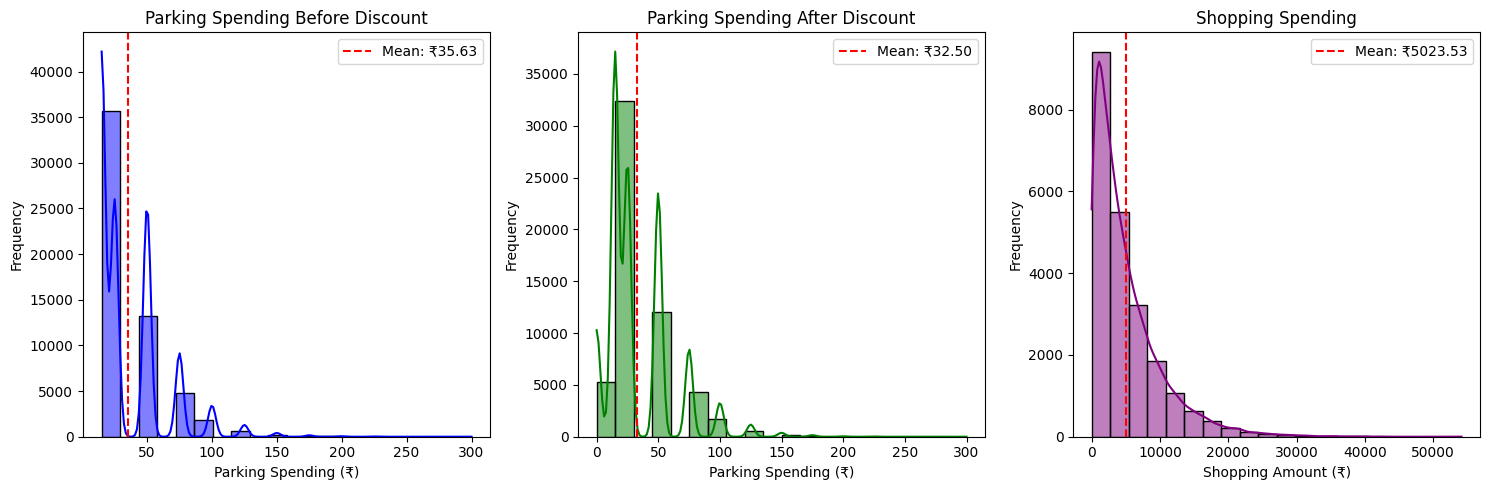

In [14]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulation parameters
SIM_DURATION = 30 * 12 * 60  # 30 days, 12 hours per day (8 AM to 8 PM)
CAPACITY = 200
WILLINGNESS_TO_VISIT = 0.80  # 80% willingness to visit (predefined threshold)
SHOPPING_PROBABILITY = 0.60  # 60% chance that a parked vehicle will shop

# Arrival rates based on the day of the week and time slots
ARRIVAL_RATES = {
    'Sunday': [(8, 12, 75), (12, 17, 250), (17, 20, 250)],
    'Monday': [(8, 12, 75), (12, 17, 250), (17, 20, 250)],
    'Tuesday': [(8, 12, 75), (12, 17, 250), (17, 20, 250)],
    'Wednesday': [(8, 12, 75), (12, 17, 250), (17, 20, 250)],
    'Thursday': [(8, 12, 75), (12, 17, 250), (17, 20, 250)],
    'Friday': [(8, 12, 100), (12, 17, 350), (17, 20, 400)],
    'Saturday': [(8, 12, 100), (12, 17, 350), (17, 20, 400)]
}

# Initialize data for tracking arrivals, inter-arrival times, parking durations, revenue, and parking space utilization
arrival_pattern = np.zeros((30, 12))  # 30 days, 12 hours per day (8 AM to 8 PM)
inter_arrival_times = [[] for _ in range(30 * 12)]  # List of lists for storing inter-arrival times for each time slot
parking_durations = []  # List to store parking durations
charges_before_discount = []  # List to store parking charges before discount
charges_after_discount = []  # List to store parking charges after discount
total_revenue_parking_before_discount = 0  # Total parking revenue before discount
total_revenue_parking_after_discount = 0  # Total parking revenue after discount
total_revenue_shopping = 0  # Total shopping revenue accumulator
lost_customers_due_to_price = 0  # Lost customers due to dissatisfaction with price
lost_customers_due_to_full = 0  # Lost customers due to parking lot being full
lost_customers_due_to_WTV = 0  # Lost customers due to WTV below threshold
parked_customers = 0  # Parked customers accumulator
spending_data = []  # List to store shopping spending
customer_log = []  # List to store detailed log of each customer
revenue_lost_due_to_WTV = 0  # Revenue lost due to WTV falling below threshold

# WTV formula parameters
x = -1.27056
y = -0.00159

# Spending parameters
mean_spending = 5000  # Mean for the exponential distribution for shopping
lambda_spending = 1 / mean_spending  # Rate parameter for the exponential distribution

def get_arrival_rate(day, hour):
    """Return the arrival rate based on the day and hour."""
    for start, end, rate in ARRIVAL_RATES[day]:
        if start <= hour < end:
            return rate
    return 0

def calculate_charge(parking_duration, discount=0):
    """Calculate the charge based on parking duration with ceiling logic and apply discount."""
    if parking_duration < 30:
        return 15 - discount
    else:
        hours = np.ceil(parking_duration / 60)  # Round up to the nearest hour
        return 25 * hours - discount  # Charge ₹25 per hour

def calculate_wtv(spending):
    """Calculate the WTV based on the shopping amount and fixed parameters."""
    return x * 25 + y * spending + 115  # WTV formula

def vehicle(env, parking_lot, day_index, hour_index, inter_arrival_time):
    """Simulates vehicle parking behavior, tracks arrivals, inter-arrival times, and calculates revenue."""
    global total_revenue_parking_before_discount, total_revenue_parking_after_discount
    global lost_customers_due_to_price, lost_customers_due_to_full, parked_customers
    global total_revenue_shopping, customer_log, lost_customers_due_to_WTV, revenue_lost_due_to_WTV
    global charges_before_discount, charges_after_discount

    # Check if the vehicle decides to park based on willingness to visit
    if np.random.random() > WILLINGNESS_TO_VISIT:
        lost_customers_due_to_price += 1
        return  # Vehicle leaves without parking
    
    with parking_lot.request() as request:
        yield request | env.timeout(0)  # Attempt to acquire a parking space

        if not request.triggered:  # If the request was not triggered, parking is full
            lost_customers_due_to_full += 1
            return  # Vehicle leaves without parking

        # Successfully parked
        parked_customers += 1

        # Generate parking duration (in minutes)
        parking_duration = np.random.exponential(60)  # Exponential distribution with mean 60 minutes
        parking_durations.append(parking_duration)  # Store parking duration

        # Calculate the parking charge before discount
        charge_before_discount = calculate_charge(parking_duration)
        charges_before_discount.append(charge_before_discount)
        total_revenue_parking_before_discount += charge_before_discount  # Update total parking revenue before discount
        
        # Determine if the customer will shop (60% chance)
        if np.random.random() >= SHOPPING_PROBABILITY:
            # Generate shopping spending based on exponential distribution
            spending = np.random.exponential(scale=mean_spending)
            spending_rounded = round(spending)
            spending_data.append(spending_rounded)
            total_revenue_shopping += spending_rounded

            # Determine discount and final parking charge
            if spending_rounded > 5000:
                if parking_duration < 30:
                    discount = 15
                else:
                    discount = 25
            else:
                discount = 0
            
            charge_after_discount = max(charge_before_discount - discount, 0)  # Ensure charge is not negative
            charges_after_discount.append(charge_after_discount)
            total_revenue_parking_after_discount += charge_after_discount  # Update total parking revenue after discount

            # Calculate WTV of the customer
            wtv_of_arrived_customer = calculate_wtv(spending_rounded)

            # If WTV is less than 50, consider the customer lost due to WTV below threshold
            if wtv_of_arrived_customer < 70:
                lost_customers_due_to_WTV += 1
                revenue_lost_due_to_WTV += charge_after_discount
                return  # Customer leaves, no parking revenue

            # Log customer details
            customer_log.append({
                'Parking Duration (mins)': round(parking_duration, 2),
                'Shopping Amount': spending_rounded,  # Rounded shopping amount
                'Parking Charge Before Discount': charge_before_discount,
                'Discount': discount,
                'Final Parking Charge': charge_after_discount,
                'WTV': round(wtv_of_arrived_customer, 2)
            })
        else:
            # If the customer does not shop, apply no discount
            discount = 0
            charge_after_discount = charge_before_discount
            charges_after_discount.append(charge_after_discount)
            total_revenue_parking_after_discount += charge_after_discount  # Update total parking revenue after discount

            # Log customer details for non-shoppers
            customer_log.append({
                'Parking Duration (mins)': round(parking_duration, 2),
                'Shopping Amount': 0,  # No shopping amount
                'Parking Charge Before Discount': charge_before_discount,
                'Discount': discount,
                'Final Parking Charge': charge_after_discount,
                'WTV': "N/A"  # Non-shoppers do not have WTV calculated
            })

        yield env.timeout(parking_duration)  # Simulate parking duration

        # Track arrivals for the specific day and hour

        arrival_pattern[day_index, hour_index] += 1
        # Store the inter-arrival time
        inter_arrival_times[day_index * 12 + hour_index].append(inter_arrival_time)

def arrival_process(env, parking_lot, day, day_index):
    """Simulates the arrival process based on the day and time."""
    while env.now < (day_index + 1) * 12 * 60:  # Simulate only 12 hours per day
        current_hour = (env.now // 60) % 12 + 8  # Convert minutes to simulation hour (8 AM - 8 PM)
        rate = get_arrival_rate(day, current_hour)

        # Determine the hour index (0 to 11 for 8 AM to 8 PM)
        hour_index = int(current_hour - 8)  # Adjust index to match 0-11 range

        if 0 <= hour_index < 12:  # Ensure hour_index is within valid bounds
            if rate > 0:
                inter_arrival_time = np.random.exponential(60 / rate)  # Convert hourly rate to inter-arrival time
                yield env.timeout(inter_arrival_time)
                env.process(vehicle(env, parking_lot, day_index, hour_index, inter_arrival_time))
            else:
                yield env.timeout(1)  # Wait for 1 minute if no arrival

def run_simulation():
    """Runs the simulation for 30 days."""
    env = simpy.Environment()
    parking_lot = simpy.Resource(env, capacity=CAPACITY)

    for day_index in range(30):
        day_name = list(ARRIVAL_RATES.keys())[day_index % 7]  # Cycle through days of the week
        env.process(arrival_process(env, parking_lot, day_name, day_index))

        # Simulate 12 hours of the current day
        env.run(until=(day_index + 1) * 12 * 60)

    # Calculate total attempted arrivals
    total_attempted_arrivals = (parked_customers + 
                                lost_customers_due_to_price + 
                                lost_customers_due_to_full + 
                                lost_customers_due_to_WTV)

    # Calculate the average parking charge before discount
    avg_parking_charge_before_discount = np.mean(charges_before_discount) if charges_before_discount else 0

    # Calculate the percentage of customers lost due to price dissatisfaction
    if total_attempted_arrivals > 0:
        percentage_lost_due_to_price = (lost_customers_due_to_price / total_attempted_arrivals) * 100
        percentage_lost_due_to_full = (lost_customers_due_to_full / total_attempted_arrivals) * 100
    else:
        percentage_lost_due_to_price = 0
        percentage_lost_due_to_full = 0

    # Calculate potential revenue lost due to price dissatisfaction
    potential_revenue_lost_due_to_price = lost_customers_due_to_price * avg_parking_charge_before_discount

    # Calculate the average shopping amount for those who did shop
    avg_shopping_amount = np.mean(spending_data) if spending_data else 0

    # Calculate the total shopping revenue lost due to WTV below threshold
    total_shopping_revenue_lost_due_to_WTV = lost_customers_due_to_WTV * avg_shopping_amount

    # Print results
    print(f"Total attempted arrivals: {total_attempted_arrivals}")
    print(f"Total parked customers: {parked_customers}")
    print(f"Total lost customers due to price dissatisfaction: {lost_customers_due_to_price}")
    print(f"Percentage of customers lost due to price dissatisfaction: {percentage_lost_due_to_price:.2f}%")
    print(f"Potential parking revenue lost due to price dissatisfaction: ₹{potential_revenue_lost_due_to_price:.2f}")
    print(f"Total lost customers due to parking lot full: {lost_customers_due_to_full}")
    print(f"Percentage of customers lost due to parking lot full: {percentage_lost_due_to_full:.2f}%")
    print(f"Total lost customers due to WTV below threshold: {lost_customers_due_to_WTV}")
    print(f"Total parking revenue before discount: ₹{total_revenue_parking_before_discount:.2f}")
    print(f"Total parking revenue after discount: ₹{total_revenue_parking_after_discount:.2f}")
    print(f"Total shopping revenue: ₹{total_revenue_shopping:.2f}")
    print(f"Total parking revenue lost due to WTV below threshold: ₹{revenue_lost_due_to_WTV:.2f}")
    print(f"Total shopping revenue lost due to WTV below threshold: ₹{total_shopping_revenue_lost_due_to_WTV:.2f}")

    # Calculate average inter-arrival times
    avg_inter_arrival_times = [np.mean(times) if times else 0 for times in inter_arrival_times]
    avg_inter_arrival_times_rounded = [round(time, 2) for time in avg_inter_arrival_times]

    # Plot frequency distribution
    plt.figure(figsize=(15, 5))

    # Plot Parking Spending Before Discount
    plt.subplot(1, 3, 1)
    sns.histplot(charges_before_discount, kde=True, bins=20, color='blue', edgecolor='black')
    plt.title("Parking Spending Before Discount")
    plt.xlabel("Parking Spending (₹)")
    plt.ylabel("Frequency")
    plt.axvline(np.mean(charges_before_discount), color='red', linestyle='--', label=f'Mean: ₹{np.mean(charges_before_discount):.2f}')
    plt.legend()

    # Plot Parking Spending After Discount
    plt.subplot(1, 3, 2)
    sns.histplot(charges_after_discount, kde=True, bins=20, color='green', edgecolor='black')
    plt.title("Parking Spending After Discount")
    plt.xlabel("Parking Spending (₹)")
    plt.ylabel("Frequency")
    plt.axvline(np.mean(charges_after_discount), color='red', linestyle='--', label=f'Mean: ₹{np.mean(charges_after_discount):.2f}')
    plt.legend()

    # Plot Shopping Spending
    plt.subplot(1, 3, 3)
    sns.histplot(spending_data, kde=True, bins=20, color='purple', edgecolor='black')
    plt.title("Shopping Spending")
    plt.xlabel("Shopping Amount (₹)")
    plt.ylabel("Frequency")
    plt.axvline(np.mean(spending_data), color='red', linestyle='--', label=f'Mean: ₹{np.mean(spending_data):.2f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Run the simulation
run_simulation()

